# Step 0: imports

In [217]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import math, random

import encode, source, output, additions
from note import Note

%matplotlib inline

In [218]:
song = pd.read_csv('music_notes/loch_lomond.csv')
song.columns = [c.strip() for c in song.columns.values]
songnotes = song.loc[:50,['pitch (as sharps)', 'octave']]
llnotes = []
for i in range(songnotes.shape[0]):
    note = songnotes.iloc[i]['pitch (as sharps)']
    octave = int(songnotes.iloc[i]['octave'])
    llnotes.append(Note(note).at_octave(octave))
ll_freq = [n.frequency() for n in llnotes]
# fix initial note repeats
ll_freq = ll_freq[3:]

def get_target(index):
    ''' Takes the index of the current target note
        and returns the target frequency of that note
    '''
    return ll_freq[index]

# Step 1: define a singer
We bundle all of the control and tracking of each voice into an object for easier simulation.

In [254]:
_integral_steps = 10
class Singer:
    def __init__(self, duration, adj_per_sec, max_vol = 1, pid_coeffs=None, starting_freq = 300):
        self.max_vol = max_vol
        self.duration = duration
        self.adj_per_sec = adj_per_sec
        if pid_coeffs:
            self.pid_coeffs = pid_coeffs
        self.realized = np.zeros(duration)
        self.realized[0] = starting_freq
        self.volumes = np.zeros(duration)
        self.error_integral = 0
        self.last_error = np.nan
        self.last_target = 0
        self.t = 1
        self.int_space = np.linspace(0, 1/adj_per_sec, _integral_steps)
    
    def get_last_note(self, t):
        return self.realized[t-1]
    
    def get_error(self, target, noise_range=5):
        ''' Calculates current error in order to
            inform a control routine
        '''
        error = target - self.realized[t-1]
        noise = random.uniform(-noise_range/2, noise_range/2)
        error = error + noise
        return error
    
    def get_volume(self, error):
        adj = math.log(math.log(abs(error)+math.e)+math.e)
        return self.max_vol
    
    def pid_control(self, error):
        if not self.pid_coeffs:
            raise Exception('no coeffs provided, but using PID')
        kp, ki, kd = self.pid_coeffs
        self.error_integral += (1/adj_per_sec)*error
        d_error = (self.last_error - error)*self.adj_per_sec \
                    if not np.isnan(self.last_error) \
                    else 0
        control = kp*error + ki * self.error_integral + kd * d_error
        return control
    
    def voice_model(self, state_vector, t):
        ''' Model of the effect that singer effort has
            on setting vocal pitch. Singer input on range (-1,1),
            so we simply scale this input to get a simple model of pitch.
        '''
        pitch, singer_input = state_vector
        deriv_of_pitch = singer_input
        deriv_of_control = 0
        return [deriv_of_pitch, deriv_of_control]
    
    def simulate_voice(self, control):
        diffeq_params = [self.realized[t-1], control]
        integration_output = integrate.odeint(self.voice_model, 
                                              diffeq_params, 
                                              self.int_space)
        realized_pitches, derivs_of_pitch = integration_output.T
        realized = realized_pitches[-1]
        return realized
    
    def adjustment(self, target):
        # check if need to reset integral
        if target != self.last_target:
            self.error_integral = 0
            self.last_error = np.nan
        # derive control
        error = self.get_error(target)
        control = self.pid_control(error)
        vol = self.get_volume(error)
        
        # simulate applying control
        realized = self.simulate_voice(control)
        
        # bookkeeping
        self.realized[self.t] = realized
        self.volumes[self.t] = vol
        self.last_error = error
        self.last_target = target
        self.t += 1
    def render_singing(self):
        pitch_duration = 1/self.adj_per_sec
        sounds = []
        starting_phase = random.random()
        for t in range(self.duration):
            phase = additions.get_phase(sounds[-1], new_volume=self.volumes[t]) if len(sounds) > 0 else starting_phase
            sounds.append(self.volumes[t] * source.sine(self.realized[t], pitch_duration, phase=phase))
        sound = np.concatenate([s[:-1] for s in sounds])
        return sound
        

        
        

# Step 2: simulation
In this step we see what happens when we unleash our control system on the task of keeping a singer on-pitch with the target

In [259]:
#################
# Parameters
#################
# total number of eigth notes
_notes = len(ll_freq)

# number of control adjustments per second
adj_per_sec = 8

# duration of one eigth note
note_duration = 0.5

adj_per_note = adj_per_sec * note_duration # should be integer

#################
# setup
#################
# total number of control adjustments
n = int(_notes * adj_per_note)

singers = []
for i in range(30):
    singers.append(Singer(duration = n, 
                adj_per_sec = adj_per_sec,
                pid_coeffs=(8,6,.05), max_vol=1/30,
                starting_freq=random.randint(150,500)))
#     singers.append(Singer(duration = n, 
#                 adj_per_sec = adj_per_sec,
#                 pid_coeffs=(9,0,0), max_vol=.04))

ideal = np.array(ll_freq)
target = np.zeros(n)

#################
# run simulation from t=0 to t=n-1
#################
for t in range(1,n):
    note_index = math.floor(t/adj_per_note)
    current_target = ideal[note_index]
    prev_notes = [s.get_last_note(t) for s in singers]
    approx_target = sum(prev_notes)/len(prev_notes)
#     print('target',current_target,'approx',approx_target)
    # update leaders
    for s in singers[:10]:
        s.adjustment(current_target)
    for s in singers[10:]:
        s.adjustment((2*current_target + approx_target)/3)
    
    
    # bookkeeping
    target[t] = ideal[note_index]

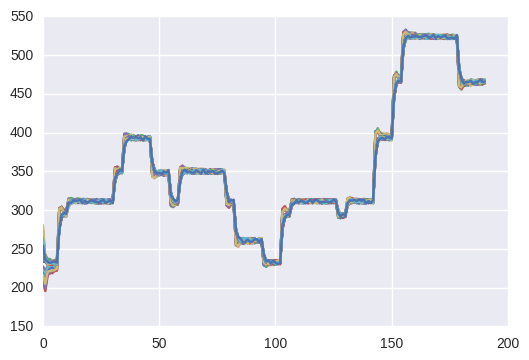

In [260]:
#################
# examine results
#################    
plt.plot(target[1:])
for s in singers:
    plt.plot(s.realized[1:])
# plt.plot(singers[20].realized[1:])

# Step 6: listen
Rather than just looking at a simple graph of the simulation, we can actually listen to the simulated pitch.

In [261]:
rendered = [s.render_singing() for s in singers]
together = sum(rendered)

In [262]:
output.play(together)